<a href="https://colab.research.google.com/github/Ishu1011/EmpAPI1/blob/master/assets/Thumb%20Classification%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training of the model for Thumb Classification

The goal of this notebook is to train a classification model that can detect thumb up and thumb down in video stream

This notebook has been run on Google Colab to take advantage of the GPU.


In [1]:
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras import optimizers
from keras.models import load_model

import seaborn as sns

Define the three classification category

In [2]:
NB_CLASSES = 3
THUMB_UP = '01'
THUMB_DOWN = '02'
OTHER = '03'
PATH_TO_ZIP = '/content/DSTI_Python_Labs/assets/data_train'
ZIP_FILE = 'thumbv3.zip'
IMAGES_RAW = 'images_raw_thumb'
IMAGES_SPLITED = 'images_keras_thumb'
MODEL_FILE = 'model_thumb_v24112020.h5'
SAVE_FOLDER = 'save_model_thumb'

## Get the training data from the github repository

In [3]:
!git clone https://github.com/EricKiennemann/DSTI_Python_Labs.git

Cloning into 'DSTI_Python_Labs'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 468 (delta 14), reused 17 (delta 4), pack-reused 434
Receiving objects: 100% (468/468), 72.44 MiB | 25.48 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Error downloading object: config/tensorflow/weights_thumb_v1.h5 (12c8985): Smudge error: Error downloading config/tensorflow/weights_thumb_v1.h5 (12c898589755e636ea9a2694fbb48115d24ab2cf74bc41c45c10704317cc5f50): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/DSTI_Python_Labs/.git/lfs/logs/20240225T165113.146035755.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: config/tensorflow/weights_thumb_v1.h5: smudge filter lfs failed
You can inspect what was checked out with 'g

In [4]:
cd $PATH_TO_ZIP

/content/DSTI_Python_Labs/assets/data_train


In [5]:
!mkdir $IMAGES_RAW

**Unzip the file training data file locally locally**

In [6]:
import zipfile
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(IMAGES_RAW)

In [7]:
!ls $IMAGES_RAW

01  02	03


## Prepare the files for the processing

Split the files into three datasets (folders) :
* "train" for training
* "valid" for validation
* "test" for test

In [8]:
def TrainValidTestFruit(category):
	# Path to the directory where the original dataset was uncompressed
	original_dataset_dir = IMAGES_RAW

	# Directory where the three datasets will be stored
	base_dir = IMAGES_SPLITED

	os.mkdir(base_dir)

	# Directory for the training splits
	train_dir = os.path.join(base_dir, 'train')
	os.mkdir(train_dir)

	# Directory for the validation splits
	valid_dir = os.path.join(base_dir, 'valid')
	os.mkdir(valid_dir)

	# Directory for the test splits
	test_dir = os.path.join(base_dir, 'test')
	os.mkdir(test_dir)

	for cat in category:
		# Directories for training categories
		train_category_dir = os.path.join(train_dir, cat)
		os.mkdir(train_category_dir)

		# Directories for validation categories
		valid_category_dir = os.path.join(valid_dir, cat)
		os.mkdir(valid_category_dir)

		# Directories for test categories
		test_category_dir = os.path.join(test_dir, cat)
		os.mkdir(test_category_dir)

		data_folder = os.path.join(original_dataset_dir, cat)
		jpgfiles = os.listdir(data_folder)

		nb_images = len(jpgfiles)
		train_ratio = 0.75				# 75% of files for training
		validation_ratio = 0.15		# 15% of files for validation
		test_ratio = 0.10					# 10% of files for test

		dataX = np.arange(nb_images)
		# train is now 75% of the entire data set
		x_train, x_test = train_test_split(dataX, test_size=1 - train_ratio)

		# test is now 10% of the initial data set
		# validation is now 15% of the initial data set
		x_valid, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio))

		# Copy the train files
		fnames = [jpgfiles[i] for i in x_train]
		for fname in fnames:
			src = os.path.join(original_dataset_dir, cat, fname)
			dst = os.path.join(train_category_dir, fname)
			shutil.copyfile(src, dst)

		# Copy the validation files
		fnames = [jpgfiles[i] for i in x_valid]
		for fname in fnames:
			src = os.path.join(original_dataset_dir, cat, fname)
			dst = os.path.join(valid_category_dir, fname)
			shutil.copyfile(src, dst)

		# Copy the test files
		fnames = [jpgfiles[i] for i in x_test]
		for fname in fnames:
			src = os.path.join(original_dataset_dir, cat, fname)
			dst = os.path.join(test_category_dir, fname)
			shutil.copyfile(src, dst)


		# Sanity Check to ensure that Training, Validation and Test Folders have the expected number of images

		print('Number of Images in Training Directory is {} for category {}'.format(len(os.listdir(train_category_dir)),cat))
		print('Number of Images in Validation Directory is {} for category {}'.format(len(os.listdir(valid_category_dir)),cat))
		print('Number of Images in Test Directory is {} for category {}'.format(len(os.listdir(test_category_dir)),cat))

# Run the creation of the three datasets on our three labels
TrainValidTestFruit([THUMB_UP,THUMB_DOWN,OTHER])

Number of Images in Training Directory is 517 for category 01
Number of Images in Validation Directory is 103 for category 01
Number of Images in Test Directory is 70 for category 01
Number of Images in Training Directory is 593 for category 02
Number of Images in Validation Directory is 118 for category 02
Number of Images in Test Directory is 80 for category 02
Number of Images in Training Directory is 260 for category 03
Number of Images in Validation Directory is 52 for category 03
Number of Images in Test Directory is 35 for category 03


The dataset is quit well balanced between 'thumb up' 517 images and 'thumb down' 593 images for training

## Building the Neural Network

We'll be using VGG16 model and the corresponding preprocessing function for the input images.

In [9]:
# include_top=false => we only take the convolutional part not the classification part.
# The image standard size is (224,224)
base_model = VGG16(include_top=False, weights='imagenet', input_shape = (224,224,3))
base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

Note that we have downloaded only a convolution part of the neural network. Let's add some dense layers on top of it.  
I choose a sigmoid activation in order to be able to dect more easelly when there is "nothing" in the screen. If the probability for both 'thumb up' and 'thumb down' are low it is likely that there is no thumb on the screen

In [10]:
flatten = Flatten()(base_model.output)
dropout_1 = Dropout(0.25)(flatten)
fc_1 = Dense(128)(dropout_1)
dropout_2 = Dropout(0.5)(fc_1)
predictions = Dense(NB_CLASSES, activation="sigmoid", name='predictions')(dropout_2)

In [11]:
model = Model(base_model.input, predictions)

**The final model structure**

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Chosing the optimizer parameters and compiling the model**  
Categorical crossentropy is choosen for this multi label classification problem

In [13]:
loss = 'categorical_crossentropy'
learning_rate = 0.001
optimizer = optimizers.SGD ## optimizers.SGD
metrics = ['accuracy']

In [14]:
model.compile(loss=loss,
              optimizer=optimizer(learning_rate),
              metrics=metrics)


## Data preparation
We will do data augmentation in order to have more data for the training.
We apply :
* rotation
* width shift
* height shift


In [15]:
train_dir = os.path.join(IMAGES_SPLITED, "train")
val_dir = os.path.join(IMAGES_SPLITED, "valid")
test_dir = os.path.join(IMAGES_SPLITED, "test")

In [16]:
# we'll resize images in correspondance to network input size
image_size = (224,224)

In [17]:
# apply some data augmentation
#
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input_vgg
                                  )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) # for validation we don't need to augment

train_batchsize = 40
val_batchsize = 40

# this function takes images from folders and feeds to Imagedatagenerator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1370 images belonging to 3 classes.
Found 273 images belonging to 3 classes.


**The data generation is only applied to the train dataset**

We do have 1370 images for training (without data augmentation) and 273 images for validation

## Model training

Starting with a number of epoch equal to 100

In [18]:
epochs = 60

In [19]:
nb_train_steps = train_generator.samples // train_generator.batch_size
nb_val_steps = validation_generator.samples // validation_generator.batch_size

In [20]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_val_steps,
      verbose=1, #0
)

<ipython-input-20-ba9885158e4d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/60
34/34 [==============================] - 61s 915ms/step - loss: nan - accuracy: 0.3759 - val_loss: nan - val_accuracy: 0.4292
Epoch 2/60
34/34 [==============================] - 24s 705ms/step - loss: nan - accuracy: 0.3729 - val_loss: nan - val_accuracy: 0.4292
Epoch 3/60
34/34 [==============================] - 24s 698ms/step - loss: nan - accuracy: 0.3767 - val_loss: nan - val_accuracy: 0.4292
Epoch 4/60
34/34 [==============================] - 24s 703ms/step - loss: nan - accuracy: 0.3767 - val_loss: nan - val_accuracy: 0.4292
Epoch 5/60
34/34 [==============================] - 25s 718ms/step - loss: nan - accuracy: 0.3759 - val_loss: nan - val_accuracy: 0.4292
Epoch 6/60
34/34 [==============================] - 25s 731ms/step - loss: nan - accuracy: 0.3782 - val_loss: nan - val_accuracy: 0.4292
Epoch 7/60
34/34 [==============================] - 24s 700ms/step - loss: nan - accuracy: 0.3767 - val_loss: nan - val_accuracy: 0.4292
Epoch 8/60
34/34 [=======================

**The accuracy for training and validation dataset are good**

In [21]:
print('training acc.:',history.history['accuracy'][-1])
print('val acc.:', (history.history['val_accuracy'])[-1])

training acc.: 0.3766917288303375
val acc.: 0.42916667461395264


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.plot(history.epoch, np.array(history.history['accuracy']),
    label='Train Accuracy')
    plt.plot(history.epoch, np.array(history.history['val_accuracy']),
    label = 'Val Accuracy')
    plt.legend()
    plt.title('Accuracy for train and validation')
    plt.ylim([0, 1.1])
    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
    label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
    label = 'Validation Loss')
    plt.legend()
    plt.title('Loss for train and validation')
    plt.show()

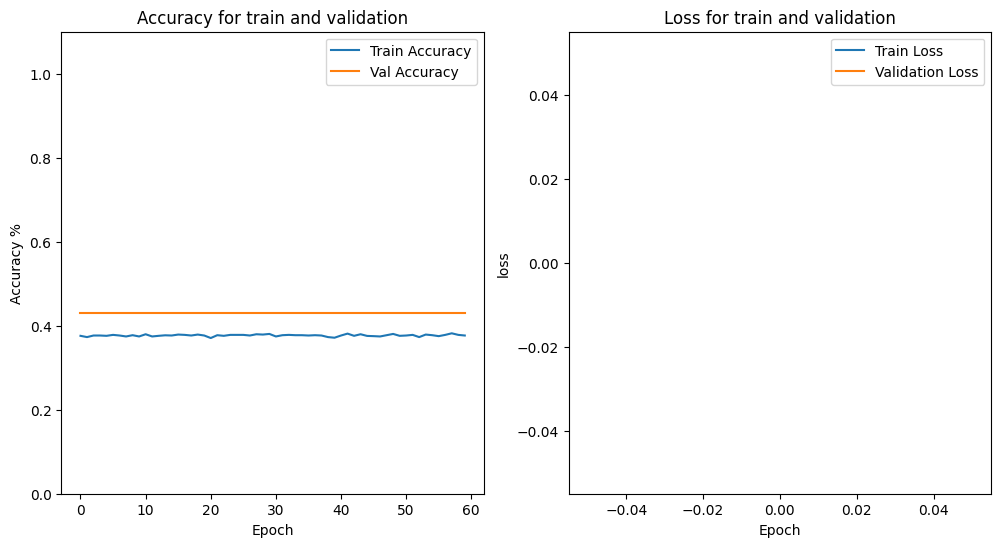

In [23]:
plot_history(history)

## Saving model

The model is saved to be used in the back end part of the web application

In [24]:
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [25]:
model_path = os.path.join(SAVE_FOLDER, MODEL_FILE)

In [26]:
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Final test on the test Dataset

In [27]:
model = load_model(model_path)

Apply the same preprocessing on the images as for validation dataset

In [28]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

Realize the prediction

In [29]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict(test_generator,steps=nb_samples)

Found 185 images belonging to 3 classes.
185/185 [==============================] - 3s 8ms/step


The prediction has been done for 185 images

**See the result of the prediction**

In [30]:
def show_classification_confusion_matrix(y_valid,y_fit,list_classes):
  print(classification_report(y_valid, y_fit,
                            target_names = list_classes))
  mat = confusion_matrix(y_valid, y_fit)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list_classes,
            yticklabels=list_classes)
  plt.xlabel('true label')
  plt.ylabel('predicted label')


              precision    recall  f1-score   support

          01       0.38      1.00      0.55        70
          02       0.00      0.00      0.00        80
          03       0.00      0.00      0.00        35

    accuracy                           0.38       185
   macro avg       0.13      0.33      0.18       185
weighted avg       0.14      0.38      0.21       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


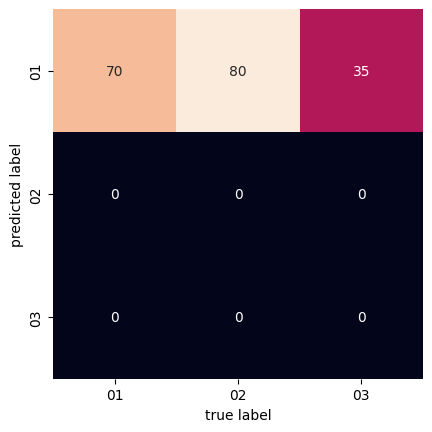

In [31]:
# choose the higher probability as the best prediction
y_pred = np.argmax(predict, axis=1)
classes = ["{:02d}".format(i) for i in range(1, 4)]

show_classification_confusion_matrix(test_generator.classes,y_pred,classes)

**All the images has been correctly predicted**

**The model is kept and will be use for the web application**

## Store the model file on a google account

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [33]:
%cp $model_path ../../../gdrive/'My Drive'